In [40]:
import requests
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import time
%matplotlib inline

## API Call functions

In [4]:
def ergast_get_standings(year, race):
    '''call ergast api to get driver standings for a giver year and race number'''
    url = f'http://ergast.com/api/f1/{year}/{race}/driverStandings.json'
    data = requests.get(url).json()

    standings = {}

    # parse json object and retrieve standings
    for x, driver in enumerate(data['MRData']['StandingsTable']['StandingsLists'][0]['DriverStandings']):
        position = driver['position']
        driver_id = driver['Driver']['driverId']
        standings[driver_id] = position
    
    # conver to df, rename the column and change data type
    standings = pd.DataFrame.from_dict(standings, orient='index').rename(columns={0:'standing'}).apply(pd.to_numeric)
    
    return standings

def ergast_get_pitstops(year, race):
    '''
    call ergast api to get pitstops for a given year and race number.
    returns a pandas dataframe containing piststops for each race of the event for each driver.
    '''

    # call API and get json object response
    url = f'http://ergast.com/api/f1/{year}/{race}/pitstops.json'
    data = requests.get(url).json()

    # empty data to append data to in the case that there are > 1 'Races' in the json object
    pitstops = pd.DataFrame()

    # parse Json object to obtain the pitstops table.
    for x, race in enumerate(data['MRData']['RaceTable']['Races']):
        pit_stops = pd.DataFrame(race['PitStops']).set_index('driverId')
        pitstops = pitstops.append(pit_stops)

    return pitstops

def ergast_get_races(year):
    url = f'http://ergast.com/api/f1/{year}/races.json'
    data = requests.get(url).json()

    race_list = []
    
    for x, race in enumerate(data['MRData']['RaceTable']['Races']):
        race_list.append(race['round'])

    return race_list

In [49]:
# groupby unique identifiers for concat (sum wins for extra analysis)
standings = pd.read_csv('f1db_csv/driver_standings.csv')
standings = standings.groupby(['raceId', 'driverId']).sum('wins')
standings


driverStandingsId  points  position  wins
raceId driverId                                           
1      2                      8256     0.0        10     0
       3                      8252     3.0         6     0
       4                      8251     4.0         5     0
       7                      8254     1.0         8     0
       8                      8261     0.0        15     0
...                            ...     ...       ...   ...
1075   848                   71284     0.0        18     0
       849                   71287     0.0        20     0
       852                   71279     4.0        11     0
       854                   71282     0.0        15     0
       855                   71281     1.0        14     0

[33455 rows x 4 columns]

In [50]:
# groupby identifiers to get unique pit times for each driver during each race, sum to get total pit time.
pit_stops = pd.read_csv('f1db_csv/pit_stops.csv')
pit_stops = pit_stops.groupby(['raceId', 'driverId']).sum().drop(columns=['stop', 'lap'])
pit_stops

milliseconds
raceId driverId              
841    1                46426
       2                48092
       3                23716
       4                72165
       5                24865
...                       ...
1075   844              21038
       846              20383
       847              21415
       848              20683
       855              48837

[4328 rows x 1 columns]

In [51]:
# concat data by index, ensuring that raceId and driverId are the same
joined_data = pd.concat([pit_stops, standings], join='inner', axis='columns')

# filter by total sum of pit time <500000 ms, removing skewness caused by outliers and excessivly long pit times.
joined_data = joined_data[joined_data['milliseconds']<500000]
joined_data

milliseconds  driverStandingsId  points  position  wins
raceId driverId                                                         
841    1                46426              64691    18.0         2     0
       2                48092              64701     0.0        12     0
       3                23716              64706     0.0        17     0
       4                72165              64693    12.0         4     0
       5                24865              64707     0.0        18     0
...                       ...                ...     ...       ...   ...
1075   844              21038              71272    45.0         1     1
       846              20383              71286     6.0        10     0
       847              21415              71275    22.0         4     0
       848              20683              71284     0.0        18     0
       855              48837              71281     1.0        14     0

[4096 rows x 5 columns]

array([[<AxesSubplot:title={'center':'milliseconds'}>]], dtype=object)

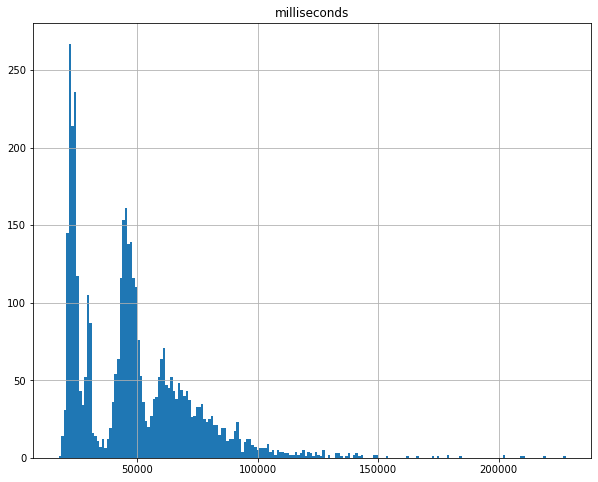

In [52]:
# multimodal data can be attributed to the modes of pit times ie: 1 stop for entire race vs 2 or 3 stops etc...
joined_data.hist('milliseconds', bins = 200, figsize=(10,8))

In [53]:
# take the average pit time for top 20 positions and plot with trendline (data becomes thin after the top 20)
avg_t_for_position = joined_data.groupby('position').mean().reset_index().head(20)
px.scatter(avg_t_for_position, x='position', y='milliseconds', trendline="ols")

## Is this causation or just correlation?
Although the trendline appears to indicate some level of correlation between pit time and final position, it is unclear if this relationship is causal. There are many factors that go into pitstops, including strategy, tracklayout, weather conditions etc. This correlation however, may indicate that teams with lower pit times are somewhat better at coordinating a team for higher win rates, and therefore pit times are a good indicator for a teams overall success.